In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
os.chdir('E:\personal project\Lending Club')

In [3]:
df = dd.read_csv('LoanStats_2015.csv',dtype='str')

In [4]:
df.loan_status.value_counts().compute()

Current               177845
Fully Paid            172354
Charged Off            60045
Late (31-120 days)      6130
In Grace Period         3227
Late (16-30 days)       1437
Default                   57
Name: loan_status, dtype: int64

In [5]:
dff=df[df.loan_status.isin(['Charged Off','Late (31-120 days),','Default'])].compute()

In [6]:
dff.shape

(60102, 145)

In [7]:
delete_col=dff.isnull().sum()[dff.isnull().sum()>30000].index.tolist()

In [15]:
delete_col

['id',
 'member_id',
 'url',
 'desc',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'revol_bal_joint',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_loan_status'

In [8]:
dff.drop(delete_col,inplace=True,axis=1)

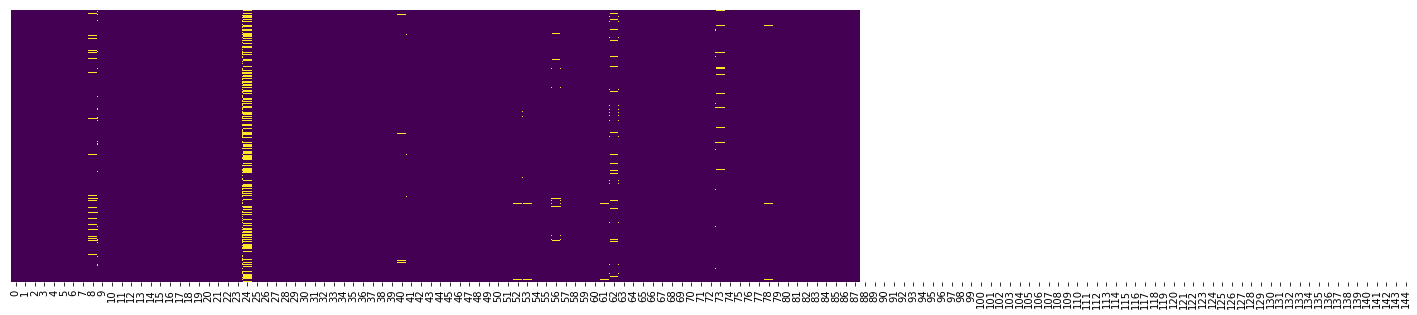

In [9]:
plt.figure(figsize=(25,5)) 
sns.set_context(font_scale=10)   
sns.heatmap(dff.isnull(),yticklabels=False,cbar=False,cmap='viridis',xticklabels=list(range(145)))

In [14]:
28260/len(dff)

0.47020065887990414

In [16]:
dff.isnull().sum()[dff.isnull().sum()>0]

emp_title                  4389
title                        10
dti                           1
mths_since_last_delinq    28260
revol_util                   25
last_pymnt_d                294
last_credit_pull_d            1
bc_open_to_buy              638
bc_util                     677
mo_sin_old_il_acct         1723
mths_since_recent_bc        613
mths_since_recent_inq      3986
num_tl_120dpd_2m           3182
percent_bc_gt_75            683
dtype: int64

In [32]:
#remove units
dff.int_rate=dff.int_rate.str[:-1]
dff.term=dff.term.str[:3]

In [33]:
dff.term

1         60
2         60
22        60
38        36
40        60
52        36
75        60
88        60
96        36
106       60
108       60
114       36
116       60
137       36
142       36
152       36
182       60
186       60
194       60
199       60
200       60
206       60
211       60
212       36
224       36
230       60
232       36
241       36
254       36
265       60
        ... 
23470     36
23476     60
23478     36
23480     36
23483     60
23484     60
23486     36
23491     60
23492     36
23495     60
23497     36
23502     60
23507     60
23512     36
23516     60
23518     36
23523     36
23528     60
23535     60
23541     36
23543     60
23551     60
23552     36
23554     36
23562     36
23570     60
23580     36
23582     36
23586     60
23587     60
Name: term, Length: 60102, dtype: object

In [37]:
dff.emp_length.value_counts()

10+ years    18482
2 years       5410
< 1 year      5071
3 years       4791
n/a           4385
1 year        4229
5 years       3571
4 years       3566
8 years       3109
7 years       2672
9 years       2415
6 years       2401
Name: emp_length, dtype: int64

In [34]:
dff.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
1,23100,23100,23100,60,20.50%,618.46,E,E4,Regional Sales Direcdtor,2 years,...,85.7,0,0,102524,55048,21700,80824,N,Cash,N
2,24250,24250,24250,60,24.24%,701.01,F,F3,hvac technician,4 years,...,63.6,0,0,344960,38475,29100,18300,N,Cash,N
22,16000,16000,16000,60,13.44%,367.67,C,C3,Merchandise Manager,1 year,...,30.8,0,0,87509,83690,23900,61109,N,Cash,N
38,27300,27300,27300,36,17.27%,977,D,D3,groundsman,10+ years,...,85.7,0,0,253900,60982,32000,37192,N,Cash,N
40,10000,10000,10000,60,17.97%,253.78,D,D4,Educator,2 years,...,100,0,0,302401,71518,11000,34953,N,Cash,N


In [18]:
dff.columns.tolist()

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old